# Deep Learning Model 

First Deep Learning model. The goal is to train a model that i can later apply for other projects. 

Dataset is Watkins Marine Mammal dataset.

The goal of the model is ...




---




Of all data we'll use:
- 70% for training
- 15% for validation
- 15% for test

## Setting up

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import random
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim

In [35]:
ROOT_PATH = Path("..")  
sys.path.append(str(ROOT_PATH))
from src.dataloaders import get_dataloaders
from src.model import EfficientNetSpectrogram
from src.model import BaselineCNN

from src.train import Trainer

In [36]:
AUDIO_DIR = ROOT_PATH / "Data" / "Audio"
ANNOT_DIR = ROOT_PATH / "Data" / "Annotations"
SPECT_DIR = ROOT_PATH / "Data" / "Spectrograms"

ANNOT_FILE = ANNOT_DIR / "audio_annotations.csv"

train_df = pd.read_csv(ANNOT_DIR / "train.csv")
val_df   = pd.read_csv(ANNOT_DIR / "val.csv")
test_df  = pd.read_csv(ANNOT_DIR / "test.csv")

## Showcase

In [37]:
df = pd.read_csv(ANNOT_FILE)
print(len(df))
print("Train:", len(train_df))
print("Val:  ", len(val_df))
print("Test: ", len(test_df))

15407
Train: 10784
Val:   2311
Test:  2312


StripedDolphin ---  shape: (1, 128, 41)
Long_FinnedPilotWhale ---  shape: (1, 128, 222)
HumpbackWhale ---  shape: (1, 128, 123)


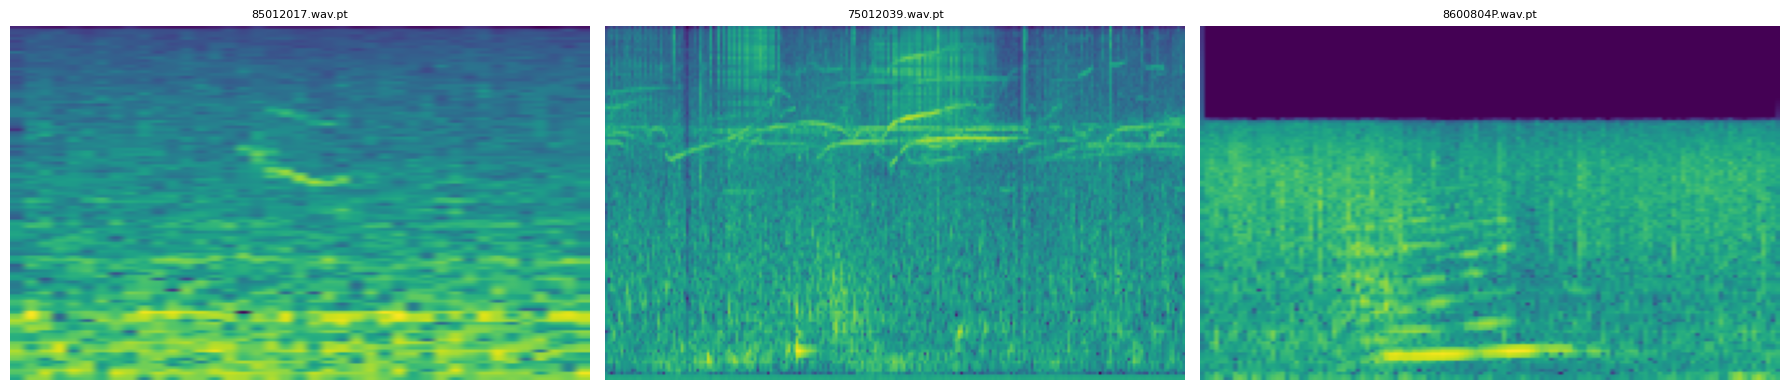

In [38]:
base_dir = ROOT_PATH / "Data" / "Spectrograms" / "train"

all_files = []
for root, dirs, files in os.walk(base_dir):
    for f in files:
        if f.endswith(".pt"):
            relative_path = os.path.join(root, f)
            all_files.append(relative_path)

if len(all_files) < 3:
    raise ValueError("Not enough .pt files found.")

# Select 3 random spectrograms
samples = random.sample(all_files, 3)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for ax, path in zip(axes, samples):
    tensor = torch.load(path)

    species_name = os.path.basename(os.path.dirname(path))
    # Print the tensor shape and name
    print(f"{species_name} ---  shape: {tuple(tensor.shape)}")

    # Convert tensor to 2D for plotting
    if tensor.dim() == 2:
        img = tensor
    elif tensor.dim() == 3:
        # assume [C, H, W]
        img = tensor[0]  
    else:
        raise ValueError(f"Unexpected tensor shape: {tensor.shape}")

    ax.imshow(img.numpy(), aspect="auto", origin="lower", cmap="viridis")
    ax.set_title(os.path.basename(path), fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

## CNN

Dataloader

In [39]:
SPEC_ROOT = ROOT_PATH / "Data" / "Spectrograms"

# Use a larger batch size and enable in-memory cache for training if RAM allows
train_loader, val_loader, test_loader = get_dataloaders(
    SPEC_ROOT,
    batch_size=32,
    num_workers=4
)

## Training

In [40]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# # Baseline training
# trainer = Trainer(
#     spectrogram_dir=ROOT_PATH / "Data" / "Spectrograms",
#     checkpoint_path=ROOT_PATH / "baseline_best.pth",
#     model_name="baseline",
#     batch_size=32,
#     max_epochs=20,
#     lr=1e-3,
#     device=device,
# )
# trainer.fit()

In [41]:
# # EfficientNet training
# eff_trainer = Trainer(
#     spectrogram_dir=ROOT_PATH / "Data" / "Spectrograms",
#     checkpoint_path=ROOT_PATH / "efficientnet_best.pth",
#     model_name="efficientnet",
#     batch_size=32,
#     max_epochs=10,
#     lr=1e-4,
#     device=device,
# )
# eff_trainer.fit()

## Evaluate

Eval baseline:   0%|          | 0/73 [00:00<?, ?it/s]c:\Users\beno7\AppData\Local\Programs\Python\Python314\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Eval baseline: 100%|██████████| 73/73 [00:41<00:00,  1.76it/s]


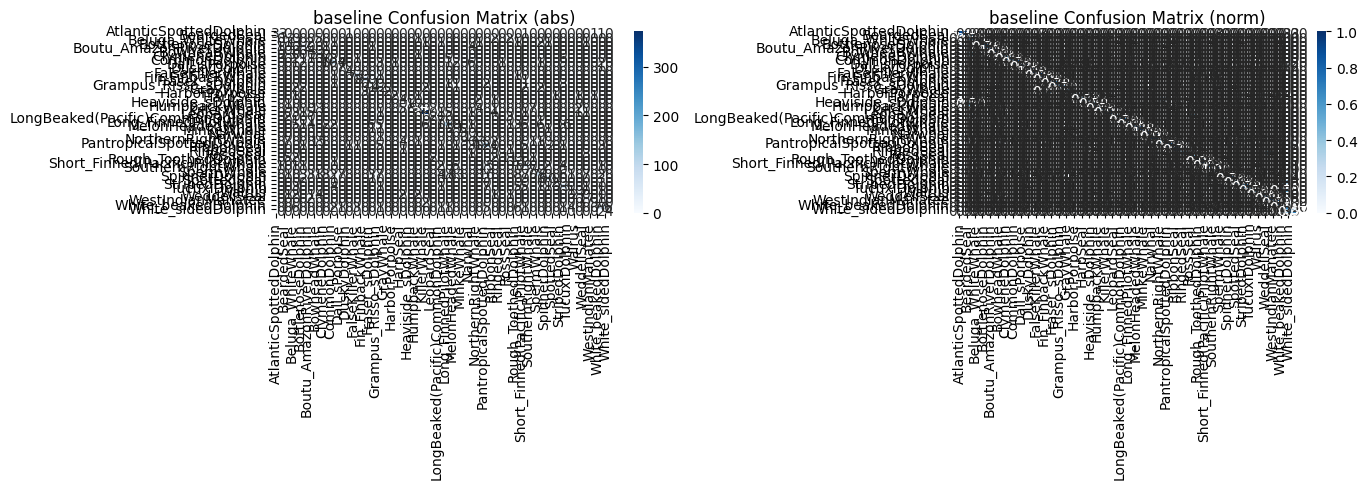

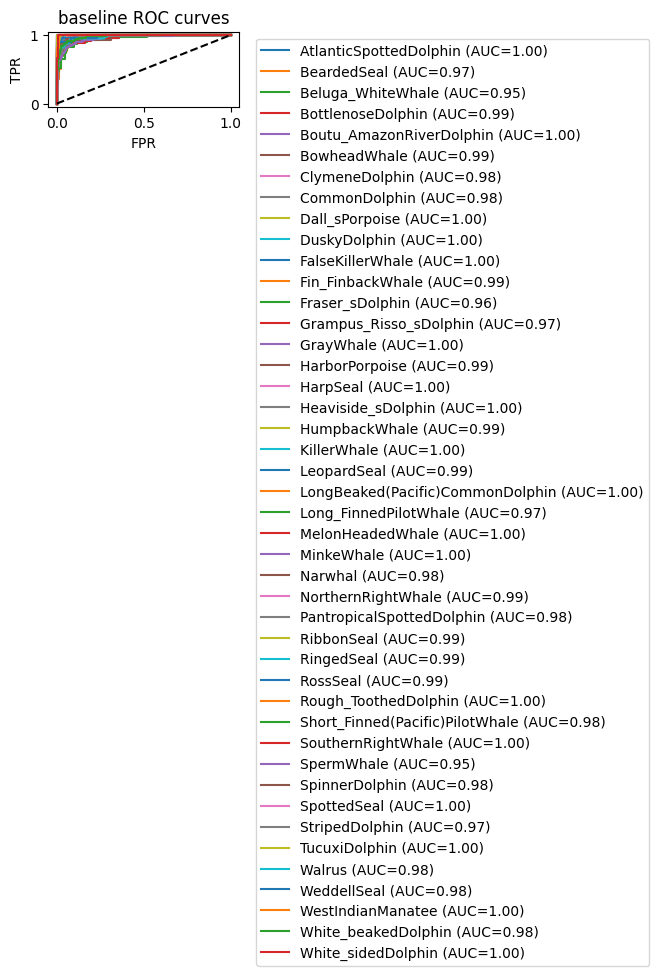

baseline summary: {'accuracy': 0.7244809688581315, 'precision_macro': 0.6148492135441619, 'recall_macro': 0.6989860524683992, 'f1_macro': 0.6103152306904474, 'top1': 0.7244809688581315, 'top3': 0.8974913494809689}


Eval efficientnet:   0%|          | 0/73 [00:00<?, ?it/s]c:\Users\beno7\AppData\Local\Programs\Python\Python314\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Eval efficientnet: 100%|██████████| 73/73 [01:22<00:00,  1.14s/it]


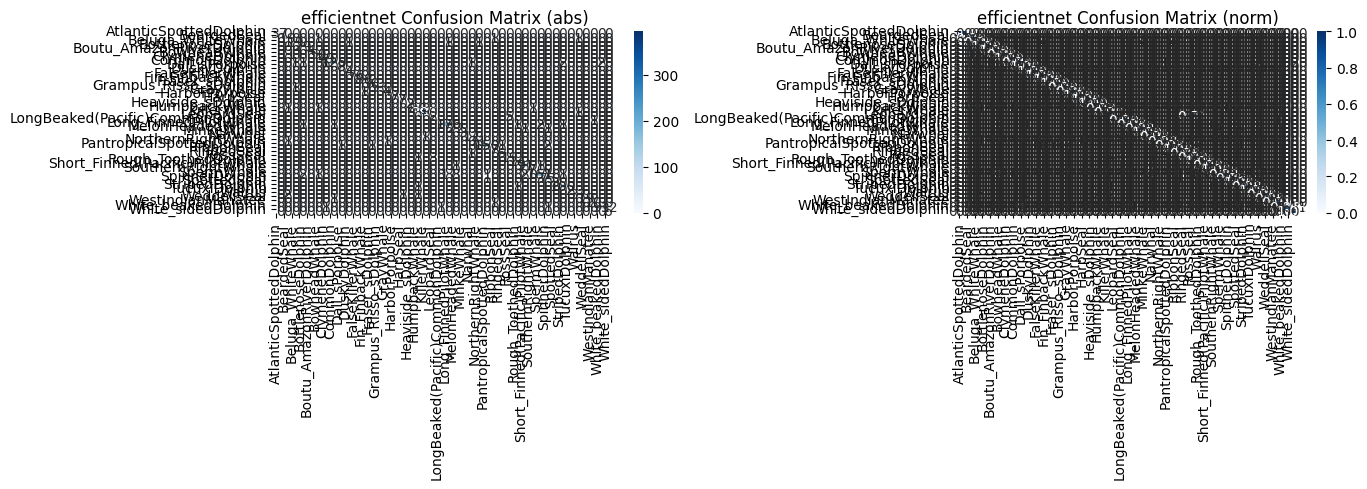

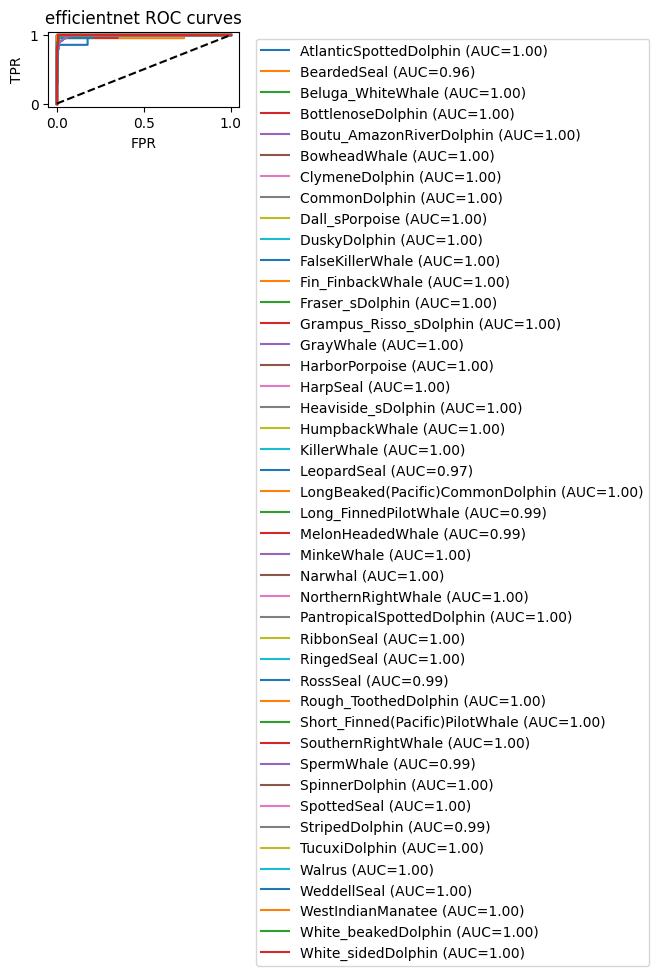

efficientnet summary: {'accuracy': 0.9467993079584776, 'precision_macro': 0.8973900571387449, 'recall_macro': 0.9355755229824957, 'f1_macro': 0.910094336031235, 'top1': 0.9467993079584776, 'top3': 0.9922145328719724}


In [42]:
# Comprehensive evaluation and reporting
import torch
import os
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(test_loader.dataset.classes)
classes = list(test_loader.dataset.classes)

OUT_DIR = ROOT_PATH / "outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

def _resolve_ckpt(preferred_name, pattern):
    p = Path(preferred_name)
    if p.exists():
        return p
    candidates = list(ROOT_PATH.glob(pattern))
    if candidates:
        return candidates[0]
    return None

def evaluate_and_report(model, loader, device, name):
    model.to(device)
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []

    with torch.no_grad():
        for xb, yb in tqdm(loader, desc=f"Eval {name}"):
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            preds = probs.argmax(axis=1)
            y_true.extend(yb.cpu().numpy().tolist())
            y_pred.extend(preds.tolist())
            y_prob.extend(probs.tolist())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    report_dict = classification_report(y_true, y_pred, target_names=classes, zero_division=0, output_dict=True)

    # Save report JSON and CSV
    report_path = OUT_DIR / f"{name}_classification_report_{timestamp}.json"
    with open(report_path, 'w') as fh:
        json.dump(report_dict, fh, indent=2)
    pd.DataFrame(report_dict).transpose().to_csv(OUT_DIR / f"{name}_report_{timestamp}.csv")

    # Confusion matrices
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    fig, axes = plt.subplots(1,2, figsize=(14,5))

    # absolute counts
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[0], cmap='Blues')
    axes[0].set_title(f"{name} Confusion Matrix (abs)")
    n = len(classes)
    axes[0].set_xticks(np.arange(n))
    axes[0].set_yticks(np.arange(n))
    axes[0].set_xticklabels(classes, rotation=90)
    axes[0].set_yticklabels(classes, rotation=0)

    # normalized
    sns.heatmap(np.nan_to_num(cm_norm), annot=True, fmt='.2f', ax=axes[1], cmap='Blues')
    axes[1].set_title(f"{name} Confusion Matrix (norm)")
    axes[1].set_xticks(np.arange(n))
    axes[1].set_yticks(np.arange(n))
    axes[1].set_xticklabels(classes, rotation=90)
    axes[1].set_yticklabels(classes, rotation=0)

    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{name}_confusion_{timestamp}.png")
    plt.show()

    # ROC curves (one-vs-rest) if possible
    try:
        if y_prob.shape[1] == len(classes):
            y_bin = label_binarize(y_true, classes=np.arange(len(classes)))
            fig, ax = plt.subplots(1,1, figsize=(7,6))
            for i, cls in enumerate(classes):
                fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
                auc = roc_auc_score(y_bin[:, i], y_prob[:, i])
                ax.plot(fpr, tpr, label=f"{cls} (AUC={auc:.2f})")
            ax.plot([0,1],[0,1], 'k--')
            ax.set_title(f"{name} ROC curves")
            ax.set_xlabel('FPR')
            ax.set_ylabel('TPR')
            ax.legend(bbox_to_anchor=(1.05,1), loc='upper left')
            plt.tight_layout()
            plt.savefig(OUT_DIR / f"{name}_roc_{timestamp}.png")
            plt.show()
    except Exception as e:
        print('ROC plotting skipped:', e)

    # Top-k accuracy
    top1 = np.mean(y_pred == y_true)
    top3 = np.mean([y_true[i] in np.argsort(-y_prob[i])[:3] for i in range(len(y_true))])

    summary = {'accuracy': float(acc), 'precision_macro': float(prec), 'recall_macro': float(rec), 'f1_macro': float(f1), 'top1': float(top1), 'top3': float(top3)}
    print(name, 'summary:', summary)

    # Save predictions and misclassifications
    df_pred = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'y_prob_max': y_prob.max(axis=1)})
    df_pred['y_true_name'] = df_pred['y_true'].apply(lambda x: classes[x])
    df_pred['y_pred_name'] = df_pred['y_pred'].apply(lambda x: classes[x])
    df_pred.to_csv(OUT_DIR / f"{name}_preds_{timestamp}.csv", index=False)
    mis = df_pred[df_pred['y_true'] != df_pred['y_pred']].head(200)
    mis.to_csv(OUT_DIR / f"{name}_misclassified_{timestamp}.csv", index=False)

    return {'summary': summary, 'report': report_dict, 'confusion_matrix': cm, 'y_true': y_true, 'y_pred': y_pred, 'y_prob': y_prob}

# Run baseline
from src.model import get_model
baseline = get_model('baseline', num_classes=num_classes)
ckpt_baseline = _resolve_ckpt('baseline_best_2.pth', '**/baseline_best*.pth')
if ckpt_baseline is None:
    raise FileNotFoundError(f"Could not find 'baseline_best_2.pth' nor any 'baseline_best*.pth' under {ROOT_PATH}")
baseline.load_state_dict(torch.load(ckpt_baseline, map_location=DEVICE))
res_baseline = evaluate_and_report(baseline, test_loader, DEVICE, 'baseline')

# Run efficientnet
eff = get_model('efficientnet', num_classes=num_classes, freeze_backbone=False)
ckpt_eff = _resolve_ckpt('efficientnet_best_2.pth', '**/efficientnet_best*.pth')
if ckpt_eff is None:
    raise FileNotFoundError(f"Could not find 'efficientnet_best_2.pth' nor any 'efficientnet_best*.pth' under {ROOT_PATH}")
eff.load_state_dict(torch.load(ckpt_eff, map_location=DEVICE))
res_eff = evaluate_and_report(eff, test_loader, DEVICE, 'efficientnet')
